### Turbo Analyzer script for running multiple files at once
A csv file will be stored in '../results/<EXPERIMENT>.csv'.
The turbo analyzer can also evaluate the average of a specific experiment, i.e.,
you run an experiment with the same parameters multiple times and store them in
a sub-folder of the targeted folder. 

The folder should have the same naming format as normal log files, but of course
without the ".txt" suffix. Files inside this folder can have any name, but 
must be suffixed with ".txt".

You will find the results printed as a dataframe at the bottom.

In [14]:
# Fill in the name of the experiment folder in logs/, .e.g 'SR1'
EXPERIMENT = "xx"

Reading experiment folder './logs/ecc_testing'...


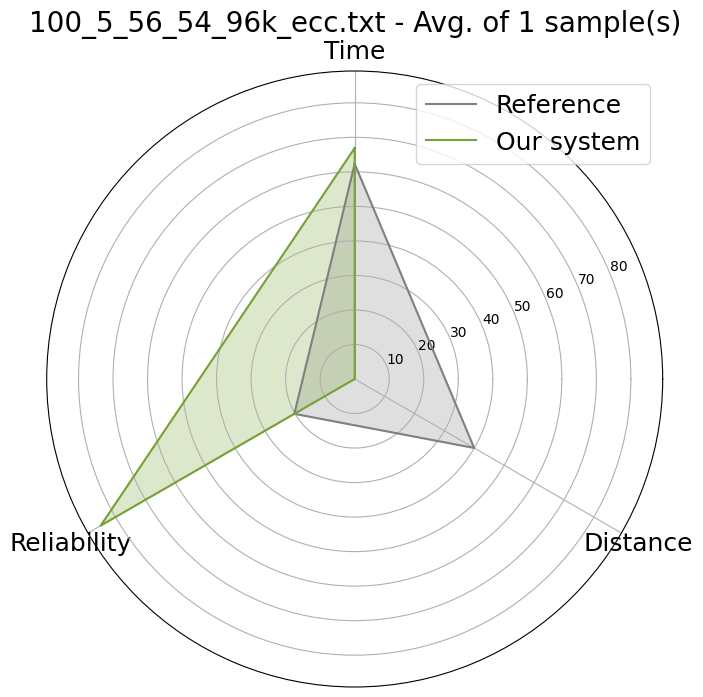

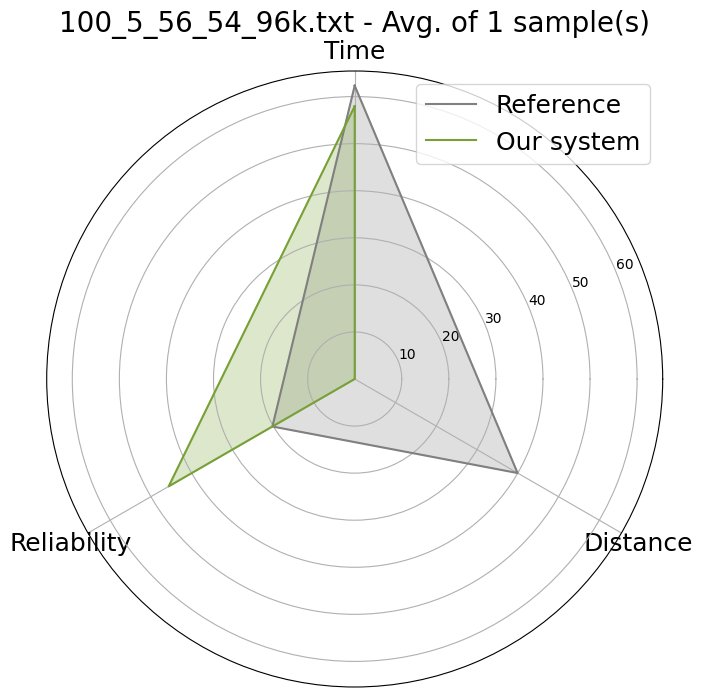

                      file   d2  d1   a   b   baud  delta_fsk file_delay_s bit_reliability dis_metric    etx avg_rssi    ecc  samples  error
1      100_5_56_54_96k.txt  100   5  56  54  96000  41.335979       57.967        45.64773     0.0025  1.394  -88.123  False        1  False
0  100_5_56_54_96k_ecc.txt  100   5  56  54  96000  41.335979       66.911       84.971421     0.0025  1.006  -87.956   True        1  False
Saving experiment data to results/ecc_testing.csv...
Successfully saved.


In [15]:
import os
import glob
import traceback
from io import StringIO
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

clock = 125
logdir = f"./logs/{EXPERIMENT}"
experiments_data = []

print(f"Reading experiment folder '{logdir}'...")
for idx, path in enumerate(glob.glob(f"{logdir}/*")):
    log_paths = []
    # We have multiple log files for this configuration and we want to 
    # read them all and get the average. 
    if os.path.isdir(path):
        log_paths = glob.glob(f"{path}/*.txt")
    elif path.endswith(".txt"):
        log_paths.append(path)

    if len(log_paths) == 0:
        continue

    dfs = [readfile(f) for f in log_paths]
    filename = os.path.basename(path)
    params = filename.removesuffix(".txt").split("_")
    experiments_data.append({
        "file": filename,
        "d2":int(params[0]), # tag to receiver (cm)
        "d1":int(params[1]), # carrier to tag (cm)
        "a": int(params[2]),
        "b": int(params[3]),
        "baud": int(params[4].replace('k', '000')),
        "delta_fsk": ((clock/int(params[3]) - clock/int(params[2])) * 1000)/2, # khz
        "file_delay_s": None,
        "bit_reliability": None,
        "dis_metric": None,
        "etx": None,
        "avg_rssi": None,
        "ecc": params[5].lower() == "ecc" if len(params) >= 6 else False,
        "samples": len(dfs),
        "error": False,
        "dfs": dfs,
    })

def avg(lst):
    if len(lst) == 0:
        return 0
    return sum(lst) / len(lst)

def analyze():
    errors = []
    experiments = pd.DataFrame()
    for idx, data in enumerate(experiments_data):
        etx_lst = []
        file_delay_s_lst = []
        bit_reliability_lst = []
        dis_metric_lst = []
        rssi_lst = []
        experiment_error = False
        use_ecc = data["ecc"]

        for df in data["dfs"]:
            try:  
                PAYLOADSIZE = 14
                if use_ecc:
                    PAYLOADSIZE *= 3
                if PAYLOADSIZE % 2 != 0:
                    print("Alarm! the payload size is not even.")
                NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
                MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B
                # delete the corrupted packets (PAYLOADSIZE + 2B pesudo sequence number)
                df = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
                df.reset_index(inplace=True)
                # replace the resettable seq number to unresettable, for the purpose of reliability calculation
                test = replace_seq(df.copy(), MAX_SEQ=256)
                test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

                file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
                file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
                ber, error, file_content, etx = compute_ber(test, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ, USE_ECC=use_ecc)
                bit_reliability = (1-ber)*100
                dis_carrier_tag = data["d1"]/100 # cm -> m
                dis_tag_rx = data["d2"]/100 # cm -> m
                dis_metric = dis_carrier_tag**2*dis_tag_rx**2
                rssi = sum([x for x in df['rssi']])/len(df)

                etx_lst.append(etx)
                file_delay_s_lst.append(file_delay_s)
                bit_reliability_lst.append(bit_reliability)
                dis_metric_lst.append(dis_metric)
                rssi_lst.append(rssi)
            except Exception as e:
                experiment_error = True
                errors.append((data["file"], "".join(traceback.format_exception(type(e), e, e.__traceback__))))

        avg_etx = avg(etx_lst)
        avg_file_delay_s = avg(file_delay_s_lst)
        avg_bit_reliability = avg(bit_reliability_lst)
        avg_dis_metric = avg(dis_metric_lst)
        avg_rssi = avg(rssi_lst)

        del data["dfs"] # do not save log file dataframes to CSV
        experiments = pd.concat([pd.DataFrame(data, index=[idx]), experiments])
        experiments.loc[idx, "etx"] = avg_etx
        experiments.loc[idx, "file_delay_s"] = avg_file_delay_s
        experiments.loc[idx, "bit_reliability"] = avg_bit_reliability
        experiments.loc[idx, "dis_metric"] = avg_dis_metric
        experiments.loc[idx, "avg_rssi"] = avg_rssi
        experiments.loc[idx, "error"] = experiment_error

        if not experiment_error:
            metrics = [avg_file_delay_s, avg_bit_reliability, avg_dis_metric]
            radar_plot(metrics, title=f"{data['file']} - Avg. of {data['samples']} sample(s)")

    if len(errors) > 0:
        print(f"{len(errors)} out of {len(experiments)} failed:")
        for (file, error) in errors:
            print(f"{file}:\n{error}")
        print("")

    print(experiments.to_string())

    filepath = Path(f"./results/{EXPERIMENT}.csv")  
    print(f"Saving experiment data to {str(filepath)}...")
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    experiments.to_csv(filepath, index=False)
    print("Successfully saved.")

if len(experiments_data) > 0:
    analyze()
else:
    print(f"No log files found in '{EXPERIMENT}'.")